# Анализ оттока клиентов

In [ ]:
# Основные библиотеки для анализа данных
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px 
# from IPython.display import display  
from difflib import get_close_matches 
from scipy import stats
from scipy.special import boxcox1p
from scipy.spatial.distance import cdist

# Библиотеки для машинного обучения
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, roc_auc_score, 
                             confusion_matrix, recall_score, 
                             precision_score, f1_score, accuracy_score, 
                             roc_curve)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2
from sklearn.cluster import KMeans
import xgboost as xgb

# Дополнительные утилиты
# import joblib
# from datetime import datetime, timedelta
# from colorcet import rainbow, fire

Загружаем все таблицы из CSV-файлов.

In [178]:
customers = pd.read_csv('data/customers.csv')
geolocation = pd.read_csv('data/geolocation.csv')
order_payments = pd.read_csv('data/order_payments.csv')
order_reviews = pd.read_csv('data/order_reviews.csv')
orders = pd.read_csv('data/orders.csv')
product_category_name_translation = pd.read_csv('data/product_category_name_translation.csv')
products = pd.read_csv('data/products.csv')
sellers = pd.read_csv('data/sellers.csv')
orders_items = pd.read_csv('data/orders_items.csv')

/var/folders/yj/076b30xn0lxg9vk66r8n44l00000gn/T/ipykernel_99543/3753809973.py:9: DtypeWarning:

Columns (1,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.



## Предварительная обработка

Проверяем список колонок в загруженных файлах, а также типы данных в таблицах.

In [179]:
print(customers.columns)

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state'],
      dtype='object')


In [180]:
customers.dtypes

customer_id                 object
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object

In [181]:
print(geolocation.columns)

Index(['Unnamed: 0', 'geolocation_zip_code_prefix', 'geolocation_lat',
       'geolocation_lng', 'geolocation_city', 'geolocation_state'],
      dtype='object')


In [182]:
geolocation.dtypes

Unnamed: 0                       int64
geolocation_zip_code_prefix      int64
geolocation_lat                float64
geolocation_lng                float64
geolocation_city                object
geolocation_state               object
dtype: object

In [183]:
print(order_payments.columns)

Index(['Unnamed: 0', 'order_id', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value'],
      dtype='object')


In [184]:
order_payments.dtypes

Unnamed: 0                int64
order_id                 object
payment_sequential        int64
payment_type             object
payment_installments      int64
payment_value           float64
dtype: object

In [185]:
print(order_reviews.columns)

Index(['Unnamed: 0', 'review_id', 'order_id', 'review_score',
       'review_comment_title', 'review_comment_message',
       'review_creation_date', 'review_answer_timestamp'],
      dtype='object')


In [186]:
order_reviews.dtypes

Unnamed: 0                  int64
review_id                  object
order_id                   object
review_score                int64
review_comment_title       object
review_comment_message     object
review_creation_date       object
review_answer_timestamp    object
dtype: object

In [187]:
print(orders.columns)

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date'],
      dtype='object')


In [188]:
orders.dtypes

order_id                         object
customer_id                      object
order_status                     object
order_purchase_timestamp         object
order_approved_at                object
order_delivered_carrier_date     object
order_delivered_customer_date    object
order_estimated_delivery_date    object
dtype: object

In [189]:
print(product_category_name_translation.columns)

Index(['Unnamed: 0', 'product_category_name', 'product_category_name_english'], dtype='object')


In [190]:
product_category_name_translation.dtypes

Unnamed: 0                        int64
product_category_name            object
product_category_name_english    object
dtype: object

In [191]:
print(products.columns)

Index(['product_id', 'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm'],
      dtype='object')


In [192]:
products.dtypes

product_id                     object
product_category_name          object
product_name_lenght           float64
product_description_lenght    float64
product_photos_qty            float64
product_weight_g              float64
product_length_cm             float64
product_height_cm             float64
product_width_cm              float64
dtype: object

In [193]:
print(sellers.columns)

Index(['Unnamed: 0', 'seller_id', 'seller_zip_code_prefix', 'seller_city',
       'seller_state'],
      dtype='object')


In [194]:
sellers.dtypes

Unnamed: 0                 int64
seller_id                 object
seller_zip_code_prefix     int64
seller_city               object
seller_state              object
dtype: object

In [195]:
print(orders_items.columns)

Index(['Unnamed: 0', 'order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value',
       'shipping_limit_date.1', 'price.1', 'freight_value.1'],
      dtype='object')


In [196]:
orders_items.dtypes

Unnamed: 0                 int64
order_id                  object
order_item_id            float64
product_id                object
seller_id                 object
shipping_limit_date       object
price                    float64
freight_value            float64
shipping_limit_date.1     object
price.1                  float64
freight_value.1          float64
dtype: object

Удаляем лишнюю колонку 'Unnamed: 0', появившуюся при импорте CSV-файлов.

In [197]:
geolocation.drop(['Unnamed: 0'], axis=1, inplace=True)
order_payments.drop(['Unnamed: 0'], axis=1, inplace=True)
order_reviews.drop(['Unnamed: 0'], axis=1, inplace=True)
product_category_name_translation.drop(['Unnamed: 0'], axis=1, inplace=True)
sellers.drop(['Unnamed: 0'], axis=1, inplace=True)
orders_items.drop(['Unnamed: 0'], axis=1, inplace=True)

В orders изменяем типы данных для всех столбцов с датами на datetime64[ns], а также создаем первый merge таблиц orders и customers по полю customer_id. 

Далее дропаем customer_id, поскольку было выявлено следующее:

в таблице customers есть customer_id и customer_unique_id, причем customer_unique_id содержит меньше уникальных значений, чем customer_id. Делаем вывод, что именно customer_unique_id является настоящим id клиента, а customer_id - это id, который был создан для каждого заказа.

In [198]:
orders = orders.assign(
    order_purchase_timestamp = pd.to_datetime(orders.order_purchase_timestamp, format='%Y-%m-%d %H:%M:%S'),
    order_approved_at = pd.to_datetime(orders.order_approved_at, format='%Y-%m-%d %H:%M:%S'),
    order_delivered_carrier_date = pd.to_datetime(orders.order_delivered_carrier_date, format='%Y-%m-%d %H:%M:%S'),
    order_delivered_customer_date = pd.to_datetime(orders.order_delivered_customer_date, format='%Y-%m-%d %H:%M:%S'),
    order_estimated_delivery_date = pd.to_datetime(orders.order_estimated_delivery_date, format='%Y-%m-%d %H:%M:%S')
)

orders = pd.merge(orders, customers[['customer_id','customer_unique_id', 'customer_city', 'customer_state']], on='customer_id', how = 'inner')
orders.drop(['customer_id'], axis=1, inplace=True)

Подсчитываем количество клиентов, совершивших более одного заказа (повторные покупки), и рассчитываем их долю относительно общего числа заказов.

In [199]:
purchase_counts = orders.groupby('customer_unique_id')['order_id'].nunique() 
repeat_customers = purchase_counts[purchase_counts > 1]
num_repeat_customers = repeat_customers.count()
N = len(orders)
print(f"{num_repeat_customers} клиентов совершили повторные покупки, это {round((num_repeat_customers/N)*100)}%")

2997 клиентов совершили повторные покупки, это 3%


Подсчитываем количество уникальных заказов для каждого клиента и записываем это значение в новый столбец quantity. Таким образом, для каждой строки в таблице orders появляется информация о том, сколько всего заказов совершил соответствующий клиент.

In [200]:
orders['quantity'] = orders.groupby('customer_unique_id')['order_id'].transform('nunique')

### merge1

Объединяем orders с order_reviews по order_id, чтобы добавить к заказам информацию о дате отзыва и его оценке.

In [201]:
merge1 = pd.merge(orders, 
                  order_reviews[['review_id', 'order_id', 'review_creation_date', 'review_score']],
                  on = 'order_id',
                  how = 'left')
print(merge1['order_id'].nunique())
merge1.dropna(inplace=True)
len(merge1)

99441


96344

Приводим review_creation_date в формат datetime.

Затем выводим типы данных столбцов в объединенной таблице merge1, чтобы убедиться, что все столбцы имеют ожидаемые типы.

In [202]:
merge1.review_creation_date = pd.to_datetime(merge1.review_creation_date, format='%Y-%m-%d %H:%M:%S')
merge1.dtypes

order_id                                 object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
customer_unique_id                       object
customer_city                            object
customer_state                           object
quantity                                  int64
review_id                                object
review_creation_date             datetime64[ns]
review_score                            float64
dtype: object

Сортируем данные по клиентам (customer_unique_id) и времени покупки заказа (order_purchase_timestamp), чтобы можно было вычислить разницу между заказами.

Вычисляем разницу между заказами для каждого клиента:

- Для клиентов с более чем одним заказом считаем разницу по времени между заказами в днях и находим медиану

- Если у клиента только один заказ, возвращаем NA

Группируем по клиентам и вычисляем медиану разницы между заказами для каждого. Результат сохраняется в новый столбец avg_days_between_orders.

Вычисляем threshold, используя среднее значение медианы по всем клиентам.

In [203]:
df_sorted = merge1.sort_values(['customer_unique_id', 'order_purchase_timestamp'])
# группируем по клиенту и вычисляем разницу между заказами
def calculate_avg_time_between_orders(group):
    if len(group) > 1:
        time_diffs = group['order_purchase_timestamp'].diff().dt.days  # разница в днях
        return time_diffs.median() #медиана
    else:
        return pd.NA  # если заказ один, возвращаем NA

avg_time_between_orders = (
    df_sorted
    .groupby('customer_unique_id')
    .apply(calculate_avg_time_between_orders)
    .reset_index(name='avg_days_between_orders')
)

threshold = avg_time_between_orders.avg_days_between_orders.mean() # среднее - 77, медиана - 25
print(f"Порог: {threshold}")

Порог: 77.12039957939011


/var/folders/yj/076b30xn0lxg9vk66r8n44l00000gn/T/ipykernel_99543/4087580358.py:13: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [204]:
# Устанавливаем точку отсчёта как на следующий день после последнего заказа
analysis_date = merge1.order_purchase_timestamp.max() + pd.Timedelta(days = 1)

# Сортируем заказы по клиенту и времени
df_sorted = merge1.sort_values(['customer_unique_id', 'order_purchase_timestamp'])

# Для каждого клиента вычисляем разницу между датами заказов
df_sorted['time_diff_days'] = df_sorted.groupby('customer_unique_id')['order_purchase_timestamp'].diff().dt.days

# Считаем медиану интервала между заказами по каждому клиенту — она характеризует их частоту покупок
customer_intervals = df_sorted.groupby('customer_unique_id')['time_diff_days'].median().reset_index()
customer_intervals.rename(columns={'time_diff_days': 'median_interval_days'}, inplace=True)

# Получаем последнюю дату заказа (last_order_date) и общее число заказов (order_count) (сводка по клиенту)
customer_stats = merge1.groupby('customer_unique_id').agg(
    last_order_date=('order_purchase_timestamp', 'max'),
    order_count=('order_id', 'nunique')
).reset_index()

# Количество дней с момента последнего заказа
customer_stats['days_since_last_order'] = (analysis_date - customer_stats['last_order_date']).dt.days

customer_features = pd.merge(customer_stats, customer_intervals, on='customer_unique_id', how='left')

# Определяем логику определения оттока
churn_threshold_multiplier = 2.0 # Сколько раз нужно выждать средний интервал, прежде чем определять возможность оттока
default_churn_days = threshold # Порог для клиентов с разовым заказом

def calculate_dynamic_churn(row):
    if row['order_count'] == 1:
        # Если у клиента только один заказ, используем глобальный threshold как порог
        return 1 if row['days_since_last_order'] > default_churn_days else 0
    elif pd.isna(row['median_interval_days']) or row['median_interval_days'] <= 0:
         # Если у клиента несколько заказов, но неполные/аномальные интервалы — также fallback на глобальный порог.
         return 1 if row['days_since_last_order'] > default_churn_days else 0
    else:
        # Иначе применяем персонализированный порог: медианный интервал * коэффициент, где коэффициент (churn_threshold_multiplier = 2.0) можно настраивать.
        personalized_threshold = row['median_interval_days'] * churn_threshold_multiplier
        return 1 if row['days_since_last_order'] > personalized_threshold else 0

customer_features['is_churned'] = customer_features.apply(calculate_dynamic_churn, axis=1)

# Объединяем полученные признаки с основным датафреймом
# Выбираем только нужные столбцы
churn_data_to_merge = customer_features[['customer_unique_id', 'is_churned', 'days_since_last_order', 'median_interval_days']]

merge1 = pd.merge(
    merge1,
    churn_data_to_merge,
    on='customer_unique_id',
    how='left'
)

(merge1['is_churned'].value_counts()/merge1.shape[0])*100 

is_churned
1    81.952171
0    18.047829
Name: count, dtype: float64

In [205]:
len(merge1)

96344

Далее объединяем products с product_category_name_translation, чтобы получить англоязычные названия категорий товаров.

In [206]:
products = pd.merge(products, 
                    product_category_name_translation, 
                    on = 'product_category_name', 
                    how = 'left')
products.drop(['product_category_name'], axis=1, inplace=True) # Удаляем оригинальное (португальское) название категории
# переименовываем английскую колонку в product_category_name для удобства
products = products.rename(columns={'product_category_name_english': 'product_category_name'})
# Приводим все названия категорий к единому виду — без лишних пробелов и в нижнем регистре
products['product_category_name'] = products['product_category_name'].str.strip().str.lower()
# Проверяем, сколько категорий осталось без перевода
products['product_category_name'].isna().sum()

np.int64(623)

In [207]:
# удаляем такие строки
products.dropna(inplace=True)

# Ищем и исправляем похожие названия категорий
# С помощью difflib ищем категории, которые похожи по написанию — это позволяет найти возможные опечатки или дубли 
#(например, home_confort и home_comfort)
close_matches = {}
unique_category=products['product_category_name'].unique()
for category in unique_category:
    matches = get_close_matches(category, unique_category, cutoff=0.8)
    if len(matches) > 1:
      print(f'{category}: {matches}')
# Корректируем вручную найденные "похожие" категории
category_corrections = {
    'home_confort': 'home_comfort',
    'home_appliances_2': 'home_appliances',
}
# Создаём словарь с исправлениями и заменяем ошибочные значения на правильные
products['product_category_name']=products['product_category_name'].replace(category_corrections)

home_appliances: ['home_appliances', 'home_appliances_2']
construction_tools_safety: ['construction_tools_safety', 'costruction_tools_garden', 'construction_tools_lights']
costruction_tools_tools: ['costruction_tools_tools', 'construction_tools_lights']
fashion_male_clothing: ['fashion_male_clothing', 'fashio_female_clothing']
construction_tools_lights: ['construction_tools_lights', 'costruction_tools_tools', 'construction_tools_safety']
home_appliances_2: ['home_appliances_2', 'home_appliances']
costruction_tools_garden: ['costruction_tools_garden', 'construction_tools_safety']
fashio_female_clothing: ['fashio_female_clothing', 'fashion_male_clothing']
home_confort: ['home_confort', 'home_comfort_2']
home_comfort_2: ['home_comfort_2', 'home_confort']


### merge2 = products + orders_items

In [208]:
orders_items.isnull().sum()

order_id                 112650
order_item_id            112650
product_id               112650
seller_id                112650
shipping_limit_date      112650
price                    112650
freight_value            112650
shipping_limit_date.1         0
price.1                       0
freight_value.1               0
dtype: int64

In [209]:
orders_items.dropna(inplace=True)

Объединяем products с orders_items по product_id, добавляя нужные столбцы (seller_id, order_id и price)

In [210]:
merge2 = pd.merge(products, 
                  orders_items[['order_id', 'seller_id', 'product_id', 'price']],
                  on = 'product_id',
                  how = 'left')

In [211]:
merge2.duplicated().sum()

np.int64(10080)

In [212]:
merge2 = merge2.drop_duplicates()

### merge3 = merge2 + sellers

Объединяем merge2 (products + orders_items) с sellers по seller_id, добавляя нужные столбцы (seller_city, seller_state)

In [213]:
merge3 = pd.merge(merge2, 
                  sellers[['seller_id', 'seller_city',	'seller_state']], 
                  on = 'seller_id',
                  how = 'left')

In [214]:
merge3.duplicated().sum()

np.int64(0)

### merge4 = merge3 + merge1

In [215]:
merge4 = pd.merge(merge1,
                  merge3,
                  on = 'order_id',
                  how = 'left')

In [216]:
len(merge4)

100000

### merge5 = merge4 + order_payments

Объединяем merge4 с order_payments по order_id, добавляя нужные столбцы (payment_type, payment_installments, payment_value)

In [217]:
merge5 = pd.merge(merge4, 
                  order_payments[['order_id', 'payment_type', 'payment_installments', 'payment_value']], 
                  on = 'order_id',
                  how = 'left')

In [218]:
merge5.duplicated().sum()

np.int64(209595)

In [219]:
merge5 = merge5.drop_duplicates()

In [220]:
merge5.isnull().sum()

order_id                             0
order_status                         0
order_purchase_timestamp             0
order_approved_at                    0
order_delivered_carrier_date         0
order_delivered_customer_date        0
order_estimated_delivery_date        0
customer_unique_id                   0
customer_city                        0
customer_state                       0
quantity                             0
review_id                            0
review_creation_date                 0
review_score                         0
is_churned                           0
days_since_last_order                0
median_interval_days             96563
product_id                        1406
product_name_lenght               1406
product_description_lenght        1406
product_photos_qty                1406
product_weight_g                  1406
product_length_cm                 1406
product_height_cm                 1406
product_width_cm                  1406
product_category_name    

In [221]:
merge5 = merge5.dropna(subset=['product_id', 'payment_type'])

In [222]:
len(merge5)

102457

In [223]:
merge5[merge5['review_id'].isna()]
merge5 = merge5.drop(['product_name_lenght', 'product_description_lenght',
       'product_photos_qty'], axis=1)

Определим разницу во времени между одобрением заказа и моментом оформления покупки заказа в секундах

In [224]:
merge5['approval_delay'] = (merge5['order_approved_at'] - merge5['order_purchase_timestamp']).dt.total_seconds()

Очистка данных от записей с нелогичным порядком событий

In [225]:
# удаляем строки, где одобрение заказа произошло после доставки клиенту — что невозможно
merge5 = merge5[merge5['order_approved_at'] < merge5['order_delivered_customer_date']]
# Удаляем строки, где одобрение заказа произошло позже, чем доставка курьеру
merge5 = merge5[merge5['order_approved_at'] < merge5['order_delivered_carrier_date']]
# Удаляем строки, где курьер получил заказ позже, чем он был доставлен клиенту
merge5 = merge5[merge5['order_delivered_carrier_date'] < merge5['order_delivered_customer_date']]

Смотрим, сколько дней прошло с момента покупки до доставки клиенту, а потом смотрим минимальное и максимальное время доставки

In [226]:
merge5['delivery_time_to_customer_days'] = (merge5['order_delivered_customer_date'] - merge5['order_purchase_timestamp']).dt.days
merge5['delivery_time_to_customer_days'].min(),merge5['delivery_time_to_customer_days'].max()

(np.int64(0), np.int64(208))

Строим гистограмму времени доставки, чтобы увидеть, насколько часто встречаются разные сроки доставки

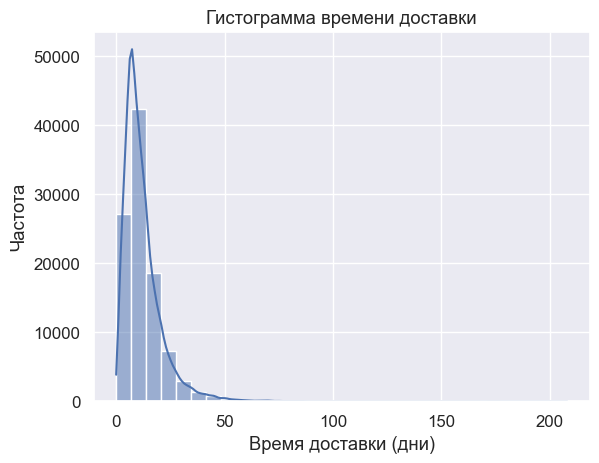

In [227]:
sns.histplot(merge5['delivery_time_to_customer_days'], kde=True, bins=30)
plt.title("Гистограмма времени доставки")
plt.xlabel("Время доставки (дни)")
plt.ylabel("Частота")
plt.show()

Вычисляем, насколько доставка укладывается в предполагаемые сроки и считаем процент вовремя доставленных заказов

In [228]:
# Считаем задержку доставки: разница между фактической и предполагаемой датой доставки
# Если значение > 0 — заказ опоздал, <= 0 — пришёл вовремя или раньше
merge5['delivery_delay'] = (merge5['order_delivered_customer_date'] - merge5['order_estimated_delivery_date']).dt.days
# Считаем, за сколько дней изначально планировалась доставка от даты покупки
merge5['estimated_delivery_time'] = (merge5['order_estimated_delivery_date'] - merge5['order_purchase_timestamp']).dt.days
# Фильтруем заказы, доставленные вовремя или раньше срока
on_time_deliveries = merge5[merge5['delivery_delay'] <= 0]
# Считаем процент вовремя доставленных заказов
on_time_percentage = (len(on_time_deliveries) / len(merge5)) * 100
print(f'Заказы доставленные вовремя: {on_time_percentage:.0f}%')

Заказы доставленные вовремя: 93%


## RFM

Далее выполняем полный RFM-анализ клиентов с подготовкой данных для кластеризации.

Сначала строим RFM-таблицу

In [229]:
rfm = merge5.groupby(by="customer_unique_id", as_index=False).agg({
    "order_approved_at": "max", # Последний заказ клиента (Recency)
    "order_id": "nunique", # Количество заказов (Frequency)
    "payment_value": "sum" # Общая сумма покупок (Monetary)
})
rfm.columns = ["customer_unique_id", "max_order_timestamp", "Frequency", "MonetaryValue"]
rfm.head()

,customer_unique_id,max_order_timestamp,Frequency,MonetaryValue
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 11:11:18,1,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 18:25:44,1,27.19
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,1,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:49:17,1,43.62
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 20:06:52,1,196.89


Вычисляем Recency — сколько дней прошло с последней покупки до самого свежего заказа в базе.

In [230]:
rfm["max_order_timestamp"] = pd.to_datetime(rfm["max_order_timestamp"])
rfm["max_order_timestamp"] = rfm["max_order_timestamp"].dt.date
recent_date = merge5["order_approved_at"].dt.date.max()
rfm["Recency"] = rfm["max_order_timestamp"].apply(lambda x: (recent_date - x).days)

rfm.drop("max_order_timestamp", axis=1, inplace=True)
rfm.head()

,customer_unique_id,Frequency,MonetaryValue,Recency
0,0000366f3b9a7992bf8c76cfdf3221e2,1,141.90,111
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,27.19,114
2,0000f46a3911fa3c0805444483337064,1,86.22,537
3,0000f6ccb0745a6a4b88665a16c9f078,1,43.62,321
4,0004aac84e0df4da2b147fca70cf8255,1,196.89,288


Визуализируем распределение RFM (строим гистограммы для Recency, Frequency, MonetaryValue)

/var/folders/yj/076b30xn0lxg9vk66r8n44l00000gn/T/ipykernel_99543/3433629006.py:3: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


/var/folders/yj/076b30xn0lxg9vk66r8n44l00000gn/T/ipykernel_99543/3433629006.py:5: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


/var/folders/yj/076b30xn0lxg9vk66r8n44l00000gn/T/ipykernel_99543/3

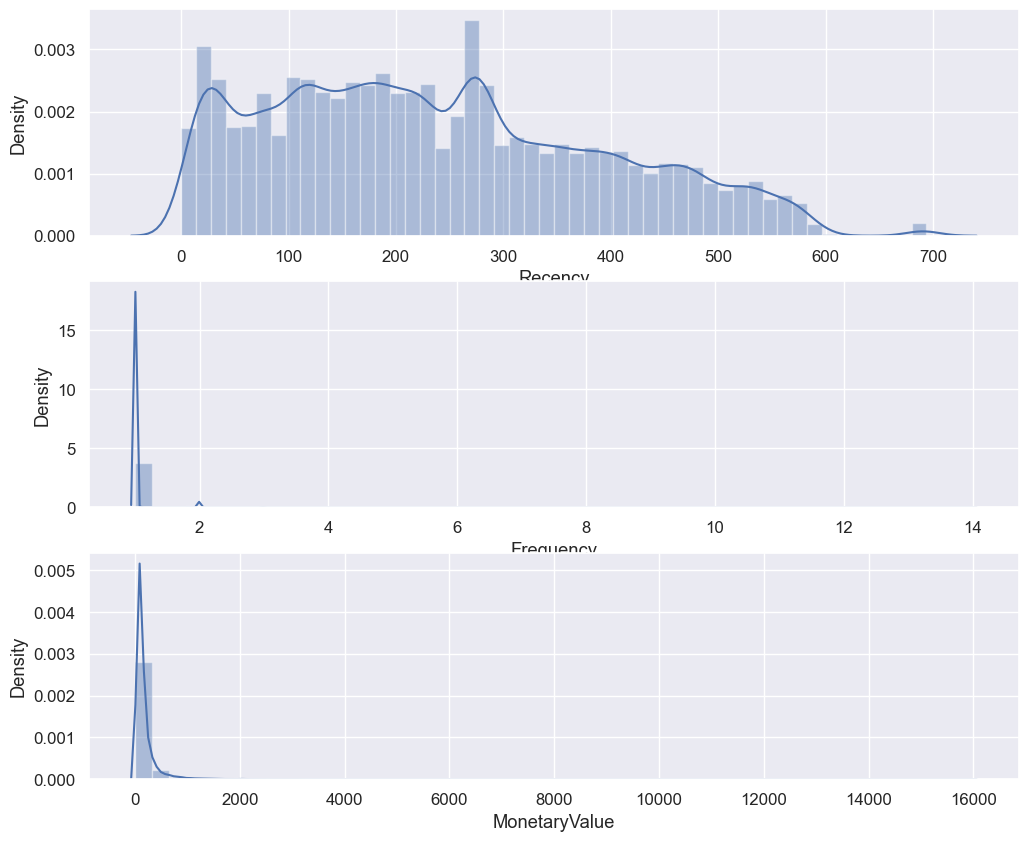

In [231]:
plt.figure(figsize=(12,10))
plt.subplot(3, 1, 1)
sns.distplot(rfm['Recency'])
plt.subplot(3, 1, 2)
sns.distplot(rfm['Frequency'])
plt.subplot(3, 1, 3)
sns.distplot(rfm['MonetaryValue'])
plt.show()

Создаем функцию анализа skewness (функция показывает, как разные трансформации (лог, sqrt, box-cox) помогают уменьшить асимметрию распределения)

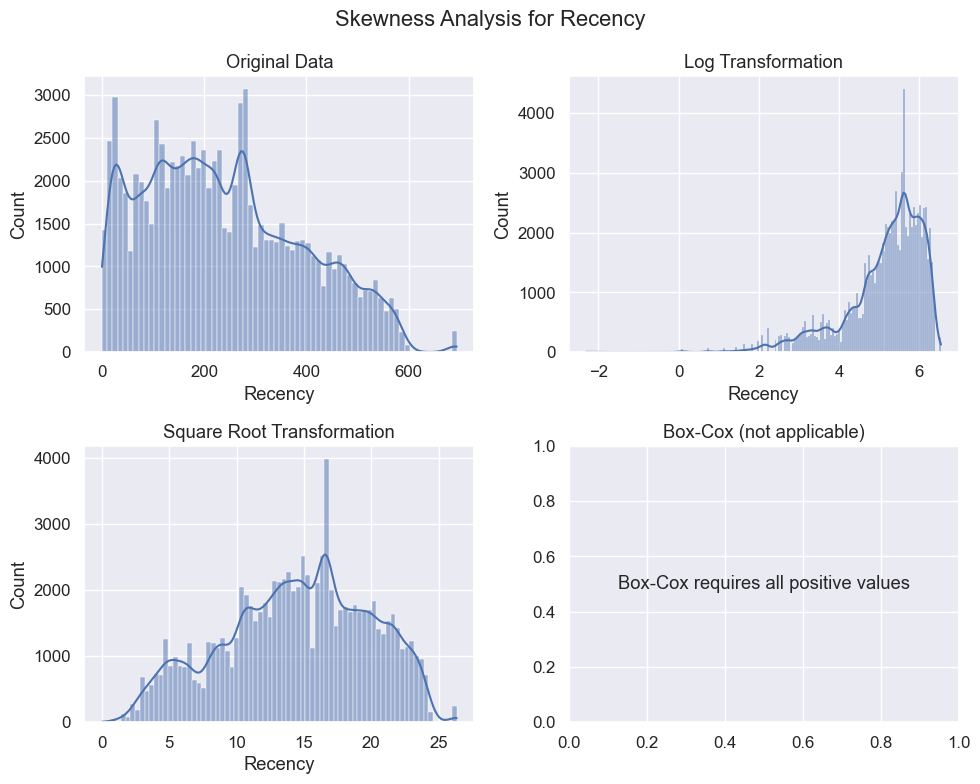

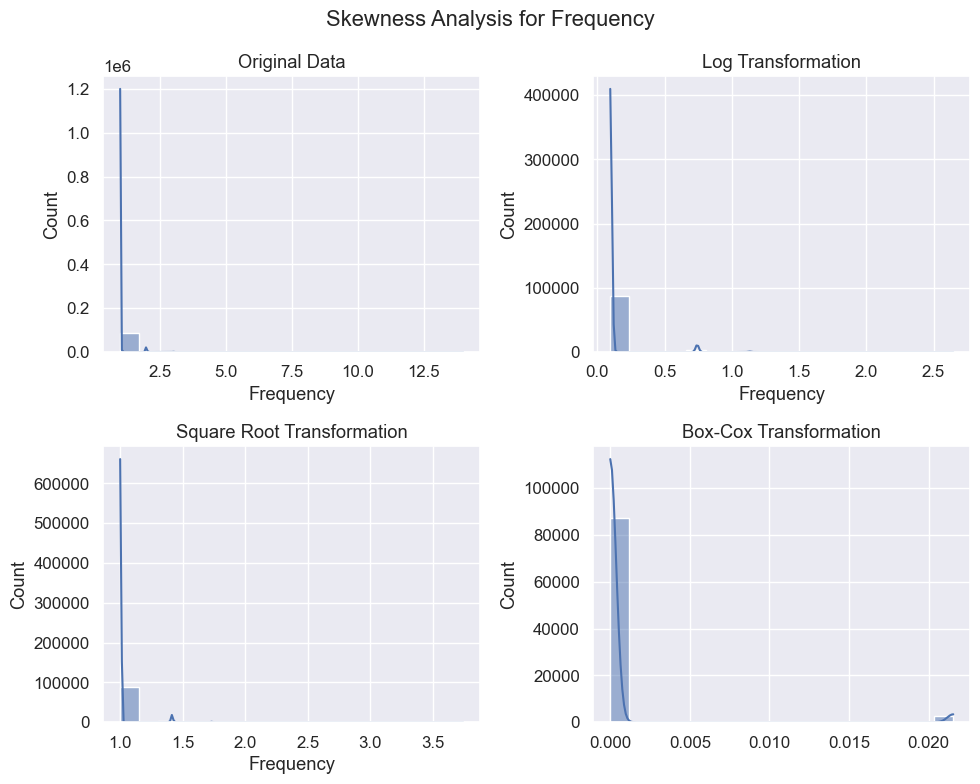

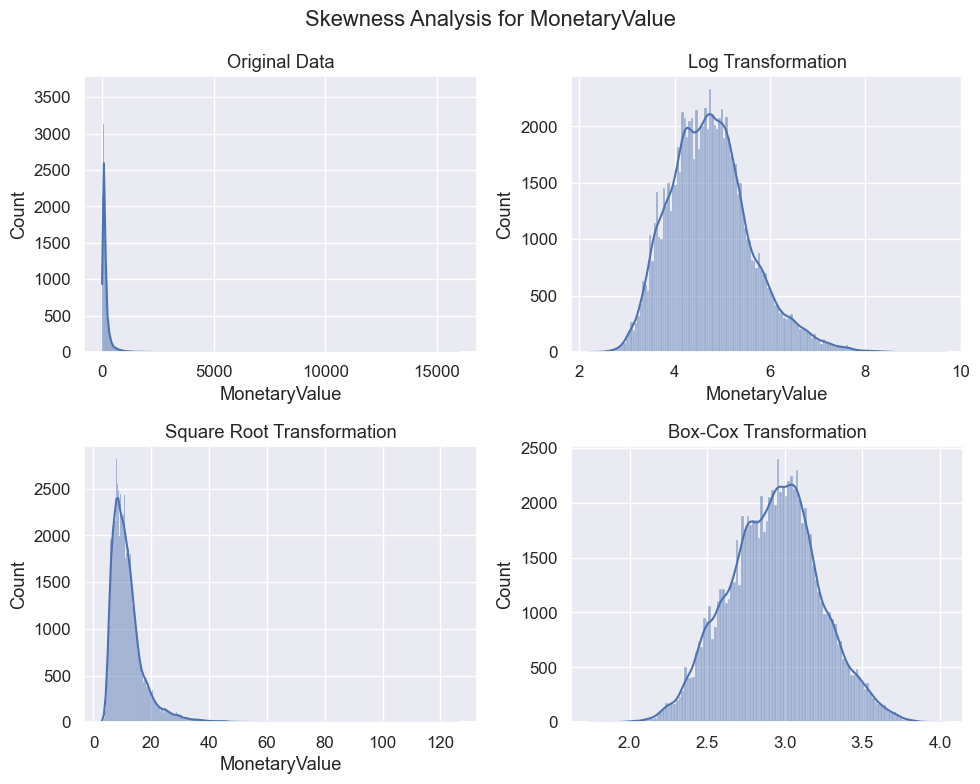

In [232]:
def analyze_skewness(x):
    fig, ax = plt.subplots(2, 2, figsize=(10, 8))
    fig.suptitle(f'Skewness Analysis for {x}')
    
    sns.histplot(rfm[x], ax=ax[0, 0], kde=True)
    ax[0, 0].set_title('Original Data')
    
    # Логарифмическое преобразование - добавляем небольшую константу (0.1) чтобы избежать log(0)
    with np.errstate(divide='ignore'):  # игнорируем предупреждения о делении на 0
        log_data = np.log(rfm[x] + 0.1) 
    sns.histplot(log_data, ax=ax[0, 1], kde=True)
    ax[0, 1].set_title('Log Transformation')
    
    # квадратный корень
    sqrt_data = np.sqrt(rfm[x])
    sns.histplot(sqrt_data, ax=ax[1, 0], kde=True)
    ax[1, 0].set_title('Square Root Transformation')
    
    # Преобразование Box-Cox - работает только с положительными значениями
    if (rfm[x] > 0).all():
        boxcox_data = stats.boxcox(rfm[x])[0]
        sns.histplot(boxcox_data, ax=ax[1, 1], kde=True)
        ax[1, 1].set_title('Box-Cox Transformation')
    else:
        # Если есть нулевые/отрицательные значения - выводим сообщение
        ax[1, 1].text(0.5, 0.5, 'Box-Cox requires all positive values', 
                     ha='center', va='center')
        ax[1, 1].set_title('Box-Cox (not applicable)')
    
    plt.tight_layout() # Автоматическая настройка отступо
    plt.show()

analyze_skewness('Recency')
analyze_skewness('Frequency')
analyze_skewness('MonetaryValue')

Преобразуем признаки, чтобы устранить перекосы и приблизить распределения к нормальному виду

In [233]:
customers_fix = pd.DataFrame()
customers_fix["Recency"] = boxcox1p(rfm['Recency'], stats.boxcox_normmax(rfm['MonetaryValue'] + 1))
customers_fix["Frequency"] = stats.boxcox(rfm['Frequency'])[0]
customers_fix["Frequency"] = rfm['Frequency']
customers_fix["MonetaryValue"] = stats.boxcox(rfm['MonetaryValue'])[0]
customers_fix

,Recency,Frequency,MonetaryValue
0,2.881393,1,3.031772
1,2.890313,1,2.355534
2,3.327425,1,2.852808
3,3.198814,1,2.574401
4,3.169736,1,3.139279
...,...,...,...
90154,3.283286,1,3.844233
90155,3.143787,1,2.845513
90156,3.340566,1,2.950659
90157,2.904562,1,3.011371


Нормализуем признаки — приводим их к одинаковому масштабу (среднее 0, стандартное отклонение 1)

In [234]:
scaler = StandardScaler()
scaler.fit(customers_fix)
customers_normalized = scaler.transform(customers_fix)
pd.DataFrame(customers_normalized).head()

,0,1,2
0,-0.308913,-0.158715,0.344324
1,-0.283294,-0.158715,-1.949592
2,0.972125,-0.158715,-0.262754
3,0.602745,-0.158715,-1.207156
4,0.519230,-0.158715,0.709006


### Кластеризация

Elbow Method — определение оптимального количества кластеров

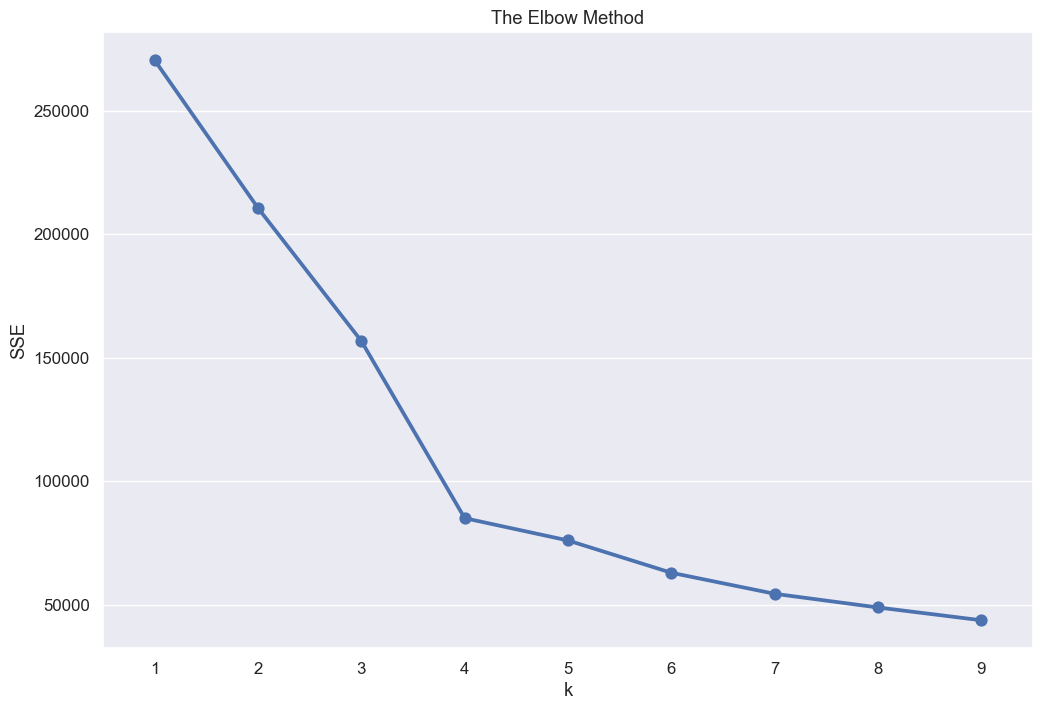

In [235]:
# Подготавливаем график и перебираем число кластеров от 1 до 9, чтобы выбрать оптимальное
plt.figure(figsize=(12,8))
K = range(1, 10)

# Для каждого значения k считаем метрики: Distortion — среднее расстояние до центроида; 
# Inertia (SSE) — сумма квадратов расстояний до ближайшего центра
distortions = []
inertias = []
mapping1 = {}
sse = {}
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customers_normalized)
    
    distortions.append(sum(np.min(cdist(customers_normalized, kmeans.cluster_centers_,
                                        'euclidean'), axis=1)) / customers_normalized.shape[0])
    inertias.append(kmeans.inertia_)
 
    mapping1[k] = sum(np.min(cdist(customers_normalized, kmeans.cluster_centers_,
                                   'euclidean'), axis=1)) / customers_normalized.shape[0]
    
    sse[k] = kmeans.inertia_ 

# Строим Elbow график, чтобы найти "локоть" — точку, где прирост эффективности от увеличения числа кластеров начинает падать.
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

Строим кластеры KMeans

In [236]:
# Создаем модель с 4 кластерами (выбрано по Elbow-методу) и добавляем метку кластера в rfm
model = KMeans(n_clusters=4, random_state=42)
model.fit(customers_normalized)
model.labels_.shape

(90159,)

In [237]:
rfm["Cluster"] = model.labels_

Анализируем кластеры - смотрим средние значения признаков по каждому кластеру — это помогает понять, какие клиенты попали в какой кластер.

In [238]:
rfm.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean', 'count']}).round(1)

Recency Frequency MonetaryValue       
           mean      mean          mean  count
Cluster                                       
0         266.1       1.0         271.9  40543
1          27.6       1.0         157.7  10852
2         271.0       1.0          59.7  36116
3         221.0       2.1         374.3   2648

Подготавливаем данные для визуализации

In [239]:
# Меняем структуру таблицы для визуализации 
df_normalized = pd.DataFrame(customers_normalized, columns=['Recency', 'Frequency', 'MonetaryValue'])
df_normalized['ID'] = rfm.index
df_normalized['Cluster'] = model.labels_

df_nor_melt = pd.melt(df_normalized.reset_index(),
                      id_vars=['ID', 'Cluster'],
                      value_vars=['Recency','Frequency','MonetaryValue'],
                      var_name='Attribute',
                      value_name='Value')

# Агрегированные данные по каждому клиенту
fig3 = df_nor_melt.groupby('Cluster').agg({'ID': lambda x: len(x)}).reset_index()

fig3.rename(columns={'ID': 'Count'}, inplace=True)
fig3['percent'] = (fig3['Count'] / fig3['Count'].sum()) * 100
fig3['percent'] = fig3['percent'].round(1)
fig3.head()

,Cluster,Count,percent
0,0,121629,45.0
1,1,32556,12.0
2,2,108348,40.1
3,3,7944,2.9


Создаем древовидную карту с помощью Plotly Express

In [240]:
# colors=['#fae588','#f79d65','#f9dc5c','#e8ac65','#e76f51','#ef233c','#b7094c']
colors=['#3a6ea5','#5d8fc7','#89b0d9','#b5d0e8']

fig = px.treemap(fig3, path=['Cluster'],values='Count'
                 , width=800, height=400
                 ,title="Дендрограмма клиентских сегментов")

fig.update_layout(
    treemapcolorway = colors, # определяет цвета в древовидной карте
    margin = dict(t=50, l=25, r=25, b=25))

fig.data[0].textinfo = 'label+text+value+percent root'
fig.show()

Линиями сравниваем поведение разных кластеров по каждому признаку

<Axes: xlabel='Attribute', ylabel='Value'>

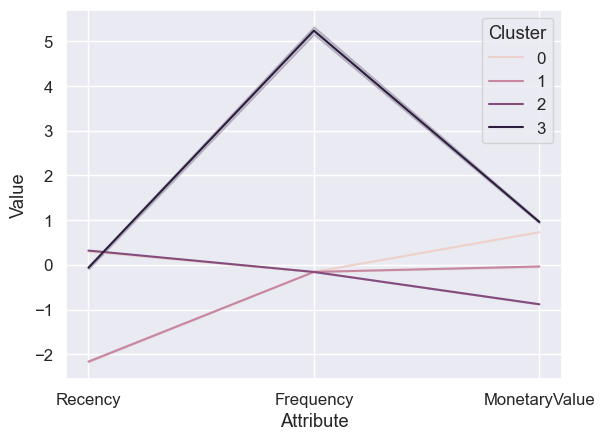

In [241]:
sns.lineplot(x='Attribute', y='Value', hue='Cluster', data=df_nor_melt)

Анализ относительной важности - сравниваем средние значения кластеров с общими, чтобы определить отклонения

In [242]:
cluster_avg = rfm[['Cluster','Recency','Frequency','MonetaryValue']].groupby(['Cluster']).mean()
population_avg = rfm[['Recency','Frequency','MonetaryValue']].head().mean()

relative_imp = cluster_avg / population_avg - 1
relative_imp.round(2)

,Recency,Frequency,MonetaryValue
Cluster,,,
0,-0.03,0.00,1.74
1,-0.90,0.00,0.59
2,-0.01,0.00,-0.40
3,-0.19,1.11,2.78


Тепловая карта отклонений — визуализирует, насколько каждый кластер отличается от среднего

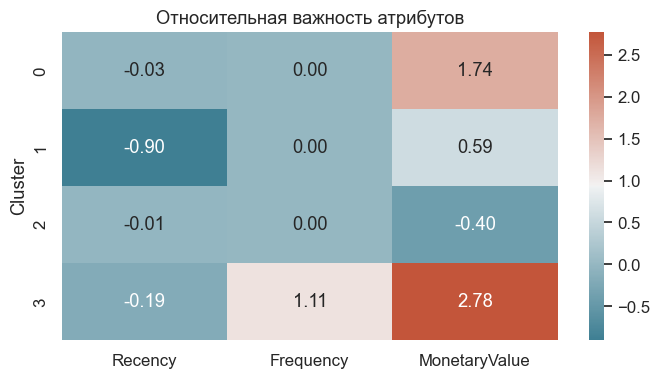

In [243]:
cmap = sns.diverging_palette(220, 20, as_cmap=True)
plt.figure(figsize=(8, 4))
plt.title('Относительная важность атрибутов')
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap=cmap)
plt.show()

RFM сегментация: присваиваем оценки

In [244]:
 # Создаем квантили для разделения клиентов по шкале от 1 до 5 для каждого параметра.
rfm['Recency'] = rfm['Recency'].fillna(0).astype(int)
rfm['Frequency'] = rfm['Frequency'].fillna(0).astype(int)
rfm['MonetaryValue'] = rfm['MonetaryValue'].fillna(0).astype(float)

numerical_cols = ['Recency', 'Frequency', 'MonetaryValue']
quantiles = rfm[numerical_cols].quantile(q=[0.2, 0.4, 0.6, 0.8]).to_dict()
    
def RScore(x,p,d):
    if x <= d[p][0.2]:
        return 5
    elif x <= d[p][0.4]:
        return 4
    elif x <= d[p][0.6]: 
        return 3
    elif x <= d[p][0.8]: 
        return 2
    else:
        return 1   
    
def FMScore(x,p,d):
    if x <= d[p][0.2]:
        return 1
    elif x <= d[p][0.4]:
        return 2
    elif x <= d[p][0.6]: 
        return 3
    elif x <= d[p][0.8]: 
        return 4
    else:
        return 5

# Присваиваем значения R, F, M на основе квантилей.
rfm['R'] = rfm['Recency'].apply(RScore, args=('Recency',quantiles,))
rfm['F'] = rfm['Frequency'].apply(FMScore, args=('Frequency',quantiles,))
rfm['M'] = rfm['MonetaryValue'].apply(FMScore, args=('MonetaryValue',quantiles,))

# Объединяем квартильные значения RFM для создания сегментов RFM
def join_rfm(x): return str(x['R']) + str(x['F']) + str(x['M'])
rfm['RFM_Segment'] = rfm.apply(join_rfm, axis=1)
# Вычисляем RFM_Score
rfm['RFM_Score'] = rfm[['R','F','M']].sum(axis=1)

In [245]:
# Создаем понятные названия
segt_map = {
    
    r'[1-2][1-2]': 'Спящие', #Hibernating
    r'[1-2][3-4]': 'В зоне риска', #At risk
    r'[1-2]5': 'Нельзя потерять', #Can\'t lose them
    r'3[1-2]': 'На грани ухода', #About to sleep
    r'33': 'Требуют внимания', #Need attention
    r'[3-4][4-5]': 'Лояльные клиенты', #Loyal customers
    r'41': 'Перспективные', #Promising
    r'51': 'Новые клиенты', #New customers
    r'[4-5][2-3]': 'Potential loyalists', #Potential loyalists
    r'5[4-5]': 'Чемпионы' #Champions
}
# Формируем сегмент и финальный балл RFM_Score.
# Присваиваем читаемые метки сегментам
rfm['Segment'] = rfm['R'].map(str) + rfm['F'].map(str)
rfm['Segment'] = rfm['Segment'].replace(segt_map, regex=True)

# Создаем понятные названия для оценок
# Определяем сегмент (Segment) и ценность клиента (Score).
rfm['Score'] = 'Стандарт'
rfm.loc[rfm['RFM_Score']>5,'Score'] = 'Бронза' 
rfm.loc[rfm['RFM_Score']>7,'Score'] = 'Серебро' 
rfm.loc[rfm['RFM_Score']>9,'Score'] = 'Золото' 
rfm.loc[rfm['RFM_Score']>10,'Score'] = 'Платина'

Визуализируем результаты

/var/folders/yj/076b30xn0lxg9vk66r8n44l00000gn/T/ipykernel_99543/380888513.py:20: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/yj/076b30xn0lxg9vk66r8n44l00000gn/T/ipykernel_99543/380888513.py:20: UserWarning:

The palette list has more values (8) than needed (7), which may not be intended.

/var/folders/yj/076b30xn0lxg9vk66r8n44l00000gn/T/ipykernel_99543/380888513.py:26: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/yj/076b30xn0lxg9vk66r8n44l00000gn/T/ipykernel_99543/380888513.py:26: UserWarning:

The palette list has more values (8) than needed (5), which may not be intended.



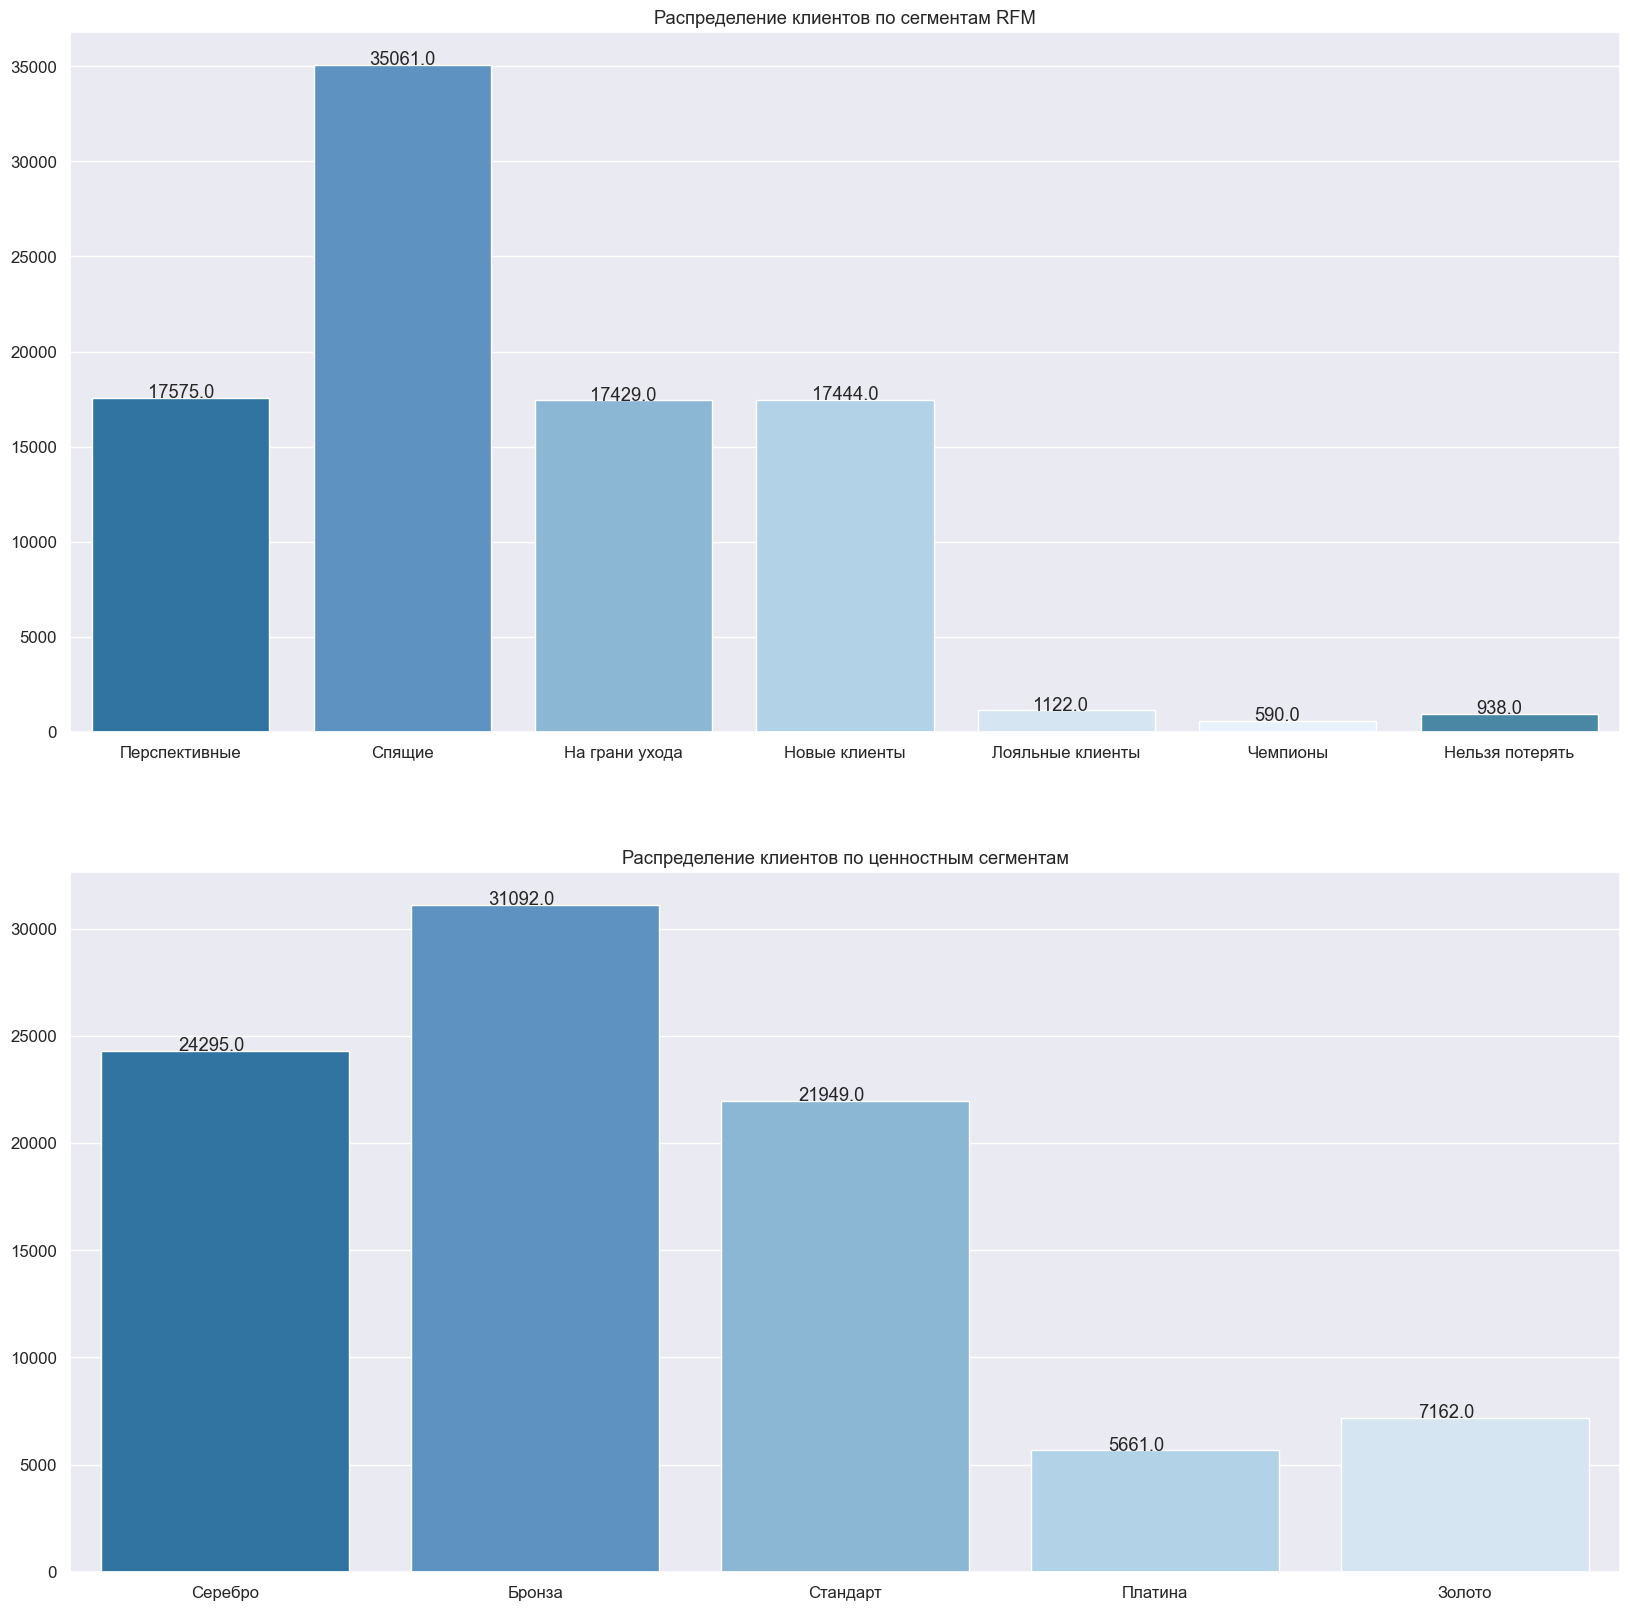

In [246]:
blue_palette = [
    '#1f77b4',  
    '#4d94d1',  
    '#7fb8e0',  
    '#a8d4f0',  
    '#d0e6f7',  
    '#e6f2ff',  
    '#3a8cb3',  
    '#5ca3c7'   
]

sns.set_theme(style="whitegrid")

fig1 = rfm.groupby(['Segment']).count().unstack().fillna(0)
fig2 = rfm.groupby(['Score']).count().unstack().fillna(0)

sns.set(font_scale=1.1)

f,ax=plt.subplots(2,1,figsize=(20,20))
sns.countplot(x='Segment',data=rfm,ax=ax[0],palette=blue_palette)

ax[0].set_xlabel('')
ax[0].set_ylabel('')
ax[0].set_title('Распределение клиентов по сегментам RFM')

sns.countplot(x='Score', data = rfm, ax = ax[1], palette = blue_palette)
ax[1].set_title('Распределение клиентов по ценностным сегментам')
ax[1].set_xlabel('')
ax[1].set_ylabel('')

for p in ax[0].patches:
    ax[0].annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+20))

for p in ax[1].patches:
    ax[1].annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+20))

plt.show()

Древовидная визуализация сегментов

In [247]:
# Считаем количество клиентов в каждом сегменте и процент от общего числа.
fig3 = rfm.groupby('Segment').agg({'customer_unique_id': lambda x: len(x)}).reset_index()

fig3.rename(columns={'customer_unique_id': 'Count'}, inplace=True)
fig3['percent'] = (fig3['Count'] / fig3['Count'].sum()) * 100
fig3['percent'] = fig3['percent'].round(1)

fig3.head()

,Segment,Count,percent
0,Лояльные клиенты,1122,1.2
1,На грани ухода,17429,19.3
2,Нельзя потерять,938,1.0
3,Новые клиенты,17444,19.3
4,Перспективные,17575,19.5


In [248]:
# Строим древовидную карту (Treemap) по сегментам.
# colors=['#fae588','#f79d65','#f9dc5c','#e8ac65','#e76f51','#ef233c','#b7094c']
colors = [
    '#1a4b7d',  
    '#3a6ea5',  
    '#5d8fc7', 
    '#89b0d9',  
    '#b5d0e8',  
    '#d9e6f2',  
    '#e6eef7',  
    '#f2f7fb'   
]

fig = px.treemap(fig3, path=['Segment'],values='Count'
                 , width=800, height=400
                 ,title="RFM сегменты")

fig.update_layout(
    treemapcolorway = colors, 
    margin = dict(t=50, l=25, r=25, b=25))

fig.data[0].textinfo = 'label+text+value+percent root'
fig.show()

Аналогично для Score и комбинаций (Cluster + Segment + Score)

In [249]:
fig4 = rfm.groupby('Score').agg({'customer_unique_id': lambda x: len(x)}).reset_index()
fig4.rename(columns={'customer_unique_id': 'Count'}, inplace=True)
fig4['percent'] = (fig4['Count'] / fig4['Count'].sum()) * 100
fig4['percent'] = fig4['percent'].round(1)

fig4.head()

,Score,Count,percent
0,Бронза,31092,34.5
1,Золото,7162,7.9
2,Платина,5661,6.3
3,Серебро,24295,26.9
4,Стандарт,21949,24.3


In [250]:
# colors=['#fae588','#f79d65','#f9dc5c','#e8ac65','#e76f51','#ef233c','#b7094c']
colors = [
    '#1a4b7d',  
    '#3a6ea5',  
    '#5d8fc7', 
    '#89b0d9',  
    '#b5d0e8',  
    '#d9e6f2',  
    '#e6eef7',  
    '#f2f7fb'   
]

fig = px.treemap(fig4, path=['Score'],values='Count'
                 , width=800, height=400
                 ,title="Дендрограмма RFM сегментов")

fig.update_layout(
    treemapcolorway = colors, 
    margin = dict(t=50, l=25, r=25, b=25))

fig.data[0].textinfo = 'label+text+value+percent root'
fig.show()

In [251]:
fig5 = rfm.groupby(['Cluster', 'Segment', 'Score']).agg({'customer_unique_id': lambda x: len(x)}).reset_index()

fig5.rename(columns={'customer_unique_id': 'Count'}, inplace=True)
fig5['percent'] = (fig5['Count'] / fig5['Count'].sum()) * 100
fig5['percent'] = fig5['percent'].round(1)

fig5.head()

colors = [
    '#3a6ea5',  
    '#5d8fc7', 
    '#89b0d9',  
    '#b5d0e8',  
    '#d9e6f2',  
    '#e6eef7',  
    '#f2f7fb'   
]

fig = px.treemap(fig5, path=[px.Constant("Customer"), 'Cluster', 'Segment', 'Score'], values='Count'
                ,title="Дендрограмма клиентских сегментов")
fig.update_traces(root_color="lightgrey")
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))

fig.update_layout(
    treemapcolorway = colors,
    margin = dict(t=50, l=25, r=25, b=25))

fig.data[0].textinfo = 'label+text+value+percent root'
fig.show()

## Фичи

Создаем список признаков

In [252]:
merge6 = pd.merge(merge5, 
                  rfm[['customer_unique_id', 'Frequency', 'MonetaryValue', 'Recency', 'R', 'F', 'M' ,'Cluster', 'RFM_Score', 'RFM_Segment']], 
                  on = 'customer_unique_id',
                  how = 'left')

In [253]:
len(merge6)

100948

In [254]:
merge6[['Frequency', 'MonetaryValue', 'Recency', 'R', 'F', 'M', 'Cluster', 'RFM_Segment']]
merge1.dropna(inplace=True)
len(merge1)

6458

In [255]:
features=[
 'customer_city',
 'customer_state',
 'order_status',
 'payment_type',
 'payment_installments',
 'payment_value',
 'review_score',
 'price',
 'product_weight_g',
 'seller_city',
 'seller_state',
 'product_category_name',
 'approval_delay',
 'delivery_time_to_customer_days',
 'estimated_delivery_time',
 'delivery_delay',
 'RFM_Score'
 ]
numerical_features=['payment_value','review_score','price','product_weight_g',
                  'approval_delay']

Разделяем фичи на категориальные и числовые

### Числовые переменные

Создаем матрицу признаков Х, удаляя целевую переменную. Определяем цель моделирования — предсказание оттока клиента (churn). y — целевая переменная (target).
И вычисляем матрицу корреляций только по числовым признакам (+ визуализируем полученную матрицу корреляций в виде тепловой карты (heatmap))


In [256]:
X = merge6.drop(['is_churned'],axis=1)
y = merge6['is_churned']

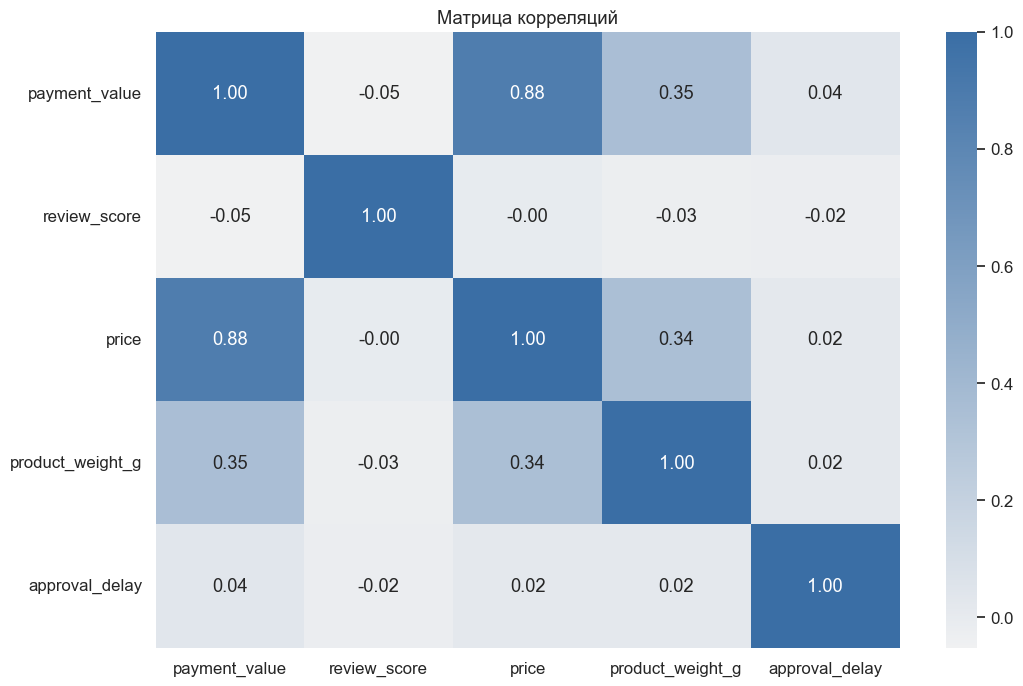

In [257]:
corr_matrix = X[numerical_features].corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap = sns.light_palette("#3a6ea5", as_cmap=True))
plt.title('Матрица корреляций')
plt.show()

In [258]:
# Проверяем, какие числовые признаки наиболее связаны с is_churned.
merge6[numerical_features + ['is_churned']].corr()['is_churned'].sort_values(ascending=True)

review_score       -0.058146
payment_value      -0.002353
price               0.004520
approval_delay      0.020950
product_weight_g    0.032006
is_churned          1.000000
Name: is_churned, dtype: float64

In [259]:
merge6['payment_value'].corr(merge6['MonetaryValue'], method='pearson')

np.float64(0.7372755233905798)

### Категориальные переменные

Кодируем все категориальные признаки в числовой формат с помощью LabelEncoder

In [260]:
# Проверка данных
print("Доступные столбцы в merge6:", merge6.columns.tolist())

# Определяем категориальные признаки
categorical_features = [
    'customer_city', 'customer_state', 'order_status', 'payment_type',
    'payment_installments', 'seller_city', 'seller_state', 'product_category_name'
]

# Проверяем наличие всех признаков
missing_features = [feat for feat in categorical_features if feat not in merge6.columns]
if missing_features:
    raise KeyError(f"Отсутствующие признаки: {missing_features}")

# Кодирование и тестирование
encoder = LabelEncoder()
encoded_data = merge6[categorical_features].apply(lambda x: encoder.fit_transform(x.astype(str)))

X = encoded_data
y = merge6['is_churned']

# Удаление пропусков
valid_indices = X.notna().all(axis=1)
X = X[valid_indices]
y = y[valid_indices]

chi_scores, p_values = chi2(X, y)

# Создаем результаты
chi2_results = pd.DataFrame({
    'Признак': categorical_features,
    'Важность (Chi2)': chi_scores,
    'p-value': p_values
}).sort_values('Важность (Chi2)', ascending=False)

print("\nРезультаты анализа:")
print(chi2_results)

Доступные столбцы в merge6: ['order_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date', 'customer_unique_id', 'customer_city', 'customer_state', 'quantity', 'review_id', 'review_creation_date', 'review_score', 'is_churned', 'days_since_last_order', 'median_interval_days', 'product_id', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'product_category_name', 'seller_id', 'price', 'seller_city', 'seller_state', 'payment_type', 'payment_installments', 'payment_value', 'approval_delay', 'delivery_time_to_customer_days', 'delivery_delay', 'estimated_delivery_time', 'Frequency', 'MonetaryValue', 'Recency', 'R', 'F', 'M', 'Cluster', 'RFM_Score', 'RFM_Segment']

Результаты анализа:
                 Признак  Важность (Chi2)        p-value
0          customer_city      8142.614540   0.000000e+00
5            seller_city       512.617141  1.709238e-

In [261]:
# Группируем данные для heatmap (пример для customer_state и product_category_name)
heatmap_data = merge6.groupby(['customer_state', 'product_category_name'])['is_churned'].mean().reset_index()

fig = px.density_heatmap(
    heatmap_data,
    x='customer_state',
    y='product_category_name',
    z='is_churned',
    color_continuous_scale='Blues',
    title='Уровень оттока по штатам и категориям товаров',
    labels={'is_churned': '% оттока'},
    width=1000,
    height=600
)

fig.update_layout(
    xaxis_title="Регион",
    yaxis_title="Категория товара",
    hovermode='closest'
)

fig.show()

In [262]:
# Проверяем распределение целевой переменной
print("\nРаспределение оттока:")
print(merge6['is_churned'].value_counts(normalize=True).apply(lambda x: f"{x:.1%}"))

# Проверяем категориальные признаки
print("\nПримеры уникальных значений:")
for col in categorical_features[:3]:  # Первые 3 признака для примера
    print(f"{col}: {merge6[col].nunique()} уникальных значений")
    print(merge6[col].value_counts().head(3))


Распределение оттока:
is_churned
1    82.4%
0    17.6%
Name: proportion, dtype: object

Примеры уникальных значений:
customer_city: 4053 уникальных значений
customer_city
sao paulo         15782
rio de janeiro     6877
belo horizonte     2805
Name: count, dtype: int64
customer_state: 27 уникальных значений
customer_state
SP    42497
RJ    13015
MG    11844
Name: count, dtype: int64
order_status: 2 уникальных значений
order_status
delivered    100941
canceled          7
Name: count, dtype: int64


## Создание модели


Обучение модели: Logistic Regression

Отчет по модели: Logistic Regression
Classification Report:
              precision    recall  f1-score   support

           0       0.28      0.59      0.38      5328
           1       0.88      0.68      0.77     24957

    accuracy                           0.66     30285
   macro avg       0.58      0.63      0.57     30285
weighted avg       0.78      0.66      0.70     30285

Specificity (TNR): 0.5865
Sensitivity (Recall/TPR): 0.6763
Precision: 0.8846
F1 Score: 0.7665
ROC-AUC: 0.6808
Accuracy: 0.6605

Confusion Matrix:
True Positives: 16879
True Negatives: 3125
False Positives: 2203
False Negatives: 8078


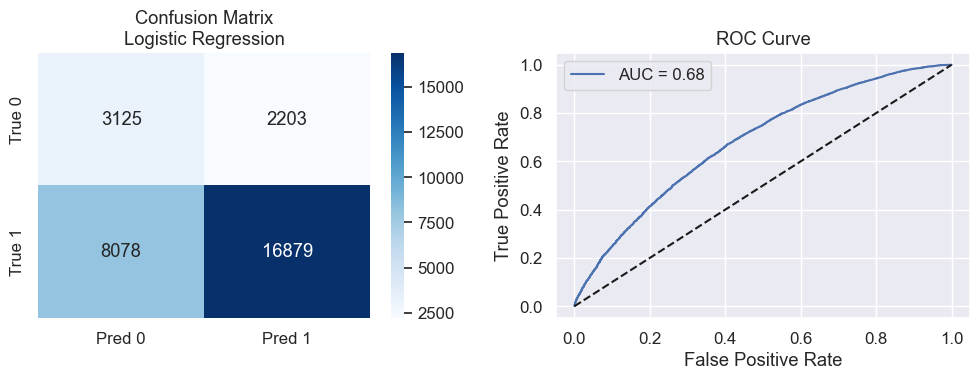


Модель Logistic Regression обучена и оценена!

Обучение модели: Decision Tree

Отчет по модели: Decision Tree
Classification Report:
              precision    recall  f1-score   support

           0       0.20      0.71      0.31      5328
           1       0.87      0.40      0.54     24957

    accuracy                           0.45     30285
   macro avg       0.53      0.55      0.43     30285
weighted avg       0.75      0.45      0.50     30285

Specificity (TNR): 0.7104
Sensitivity (Recall/TPR): 0.3967
Precision: 0.8652
F1 Score: 0.5440
ROC-AUC: 0.5695
Accuracy: 0.4519

Confusion Matrix:
True Positives: 9900
True Negatives: 3785
False Positives: 1543
False Negatives: 15057


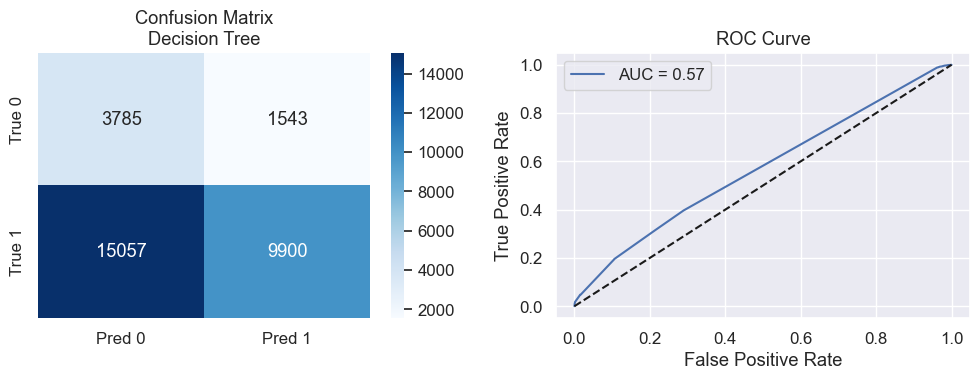

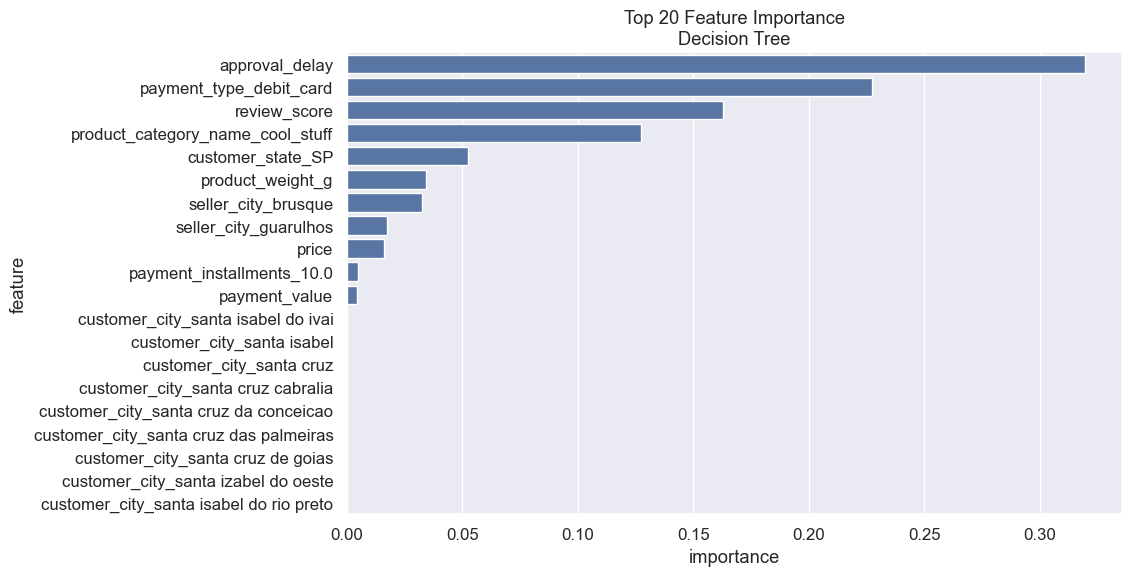


Модель Decision Tree обучена и оценена!

Обучение модели: Random Forest

Отчет по модели: Random Forest
Classification Report:
              precision    recall  f1-score   support

           0       0.26      0.56      0.35      5328
           1       0.87      0.65      0.75     24957

    accuracy                           0.64     30285
   macro avg       0.56      0.61      0.55     30285
weighted avg       0.77      0.64      0.68     30285

Specificity (TNR): 0.5608
Sensitivity (Recall/TPR): 0.6510
Precision: 0.8741
F1 Score: 0.7462
ROC-AUC: 0.6567
Accuracy: 0.6351

Confusion Matrix:
True Positives: 16246
True Negatives: 2988
False Positives: 2340
False Negatives: 8711


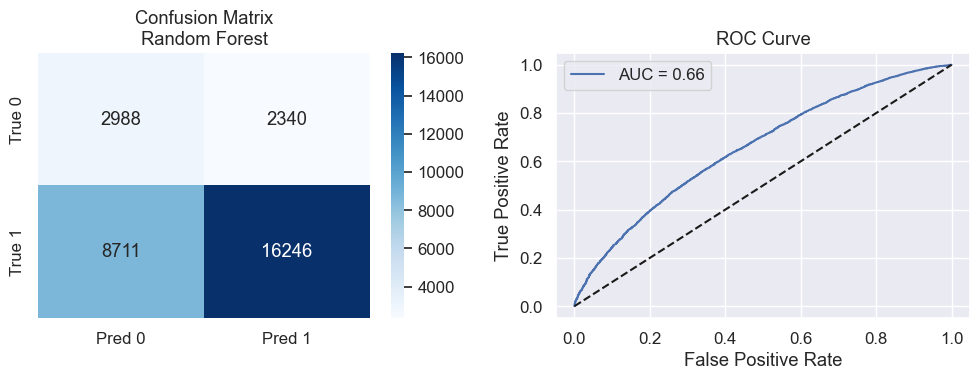

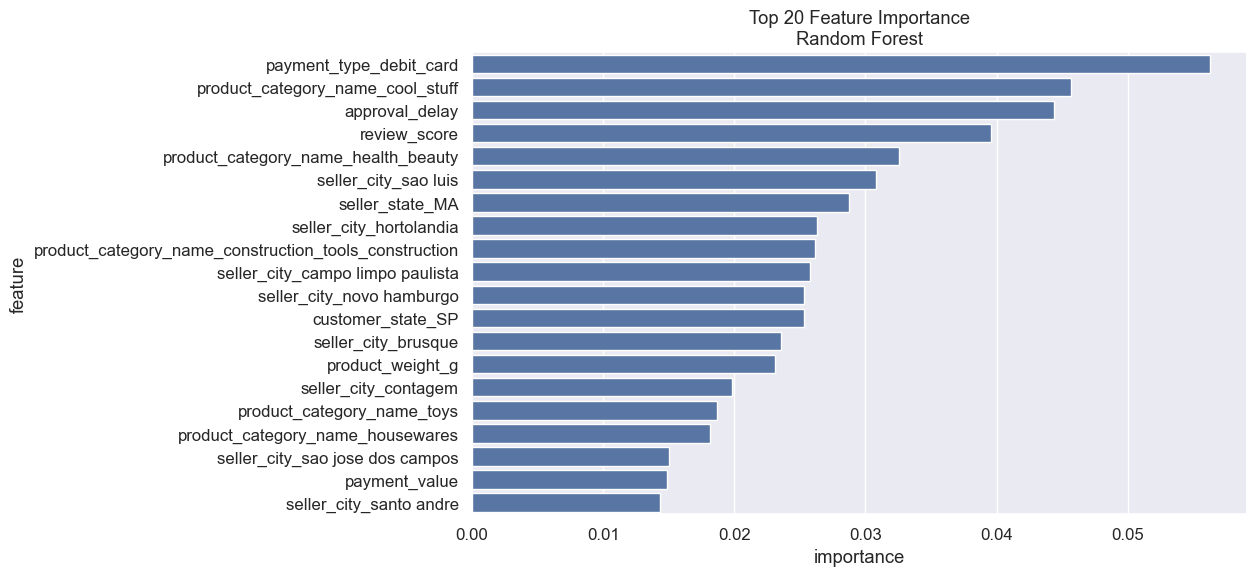


Модель Random Forest обучена и оценена!

Обучение модели: XGBoost

Отчет по модели: XGBoost
Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.64      0.40      5328
           1       0.90      0.66      0.76     24957

    accuracy                           0.66     30285
   macro avg       0.59      0.65      0.58     30285
weighted avg       0.79      0.66      0.70     30285

Specificity (TNR): 0.6361
Sensitivity (Recall/TPR): 0.6633
Precision: 0.8951
F1 Score: 0.7620
ROC-AUC: 0.7147
Accuracy: 0.6585

Confusion Matrix:
True Positives: 16553
True Negatives: 3389
False Positives: 1939
False Negatives: 8404


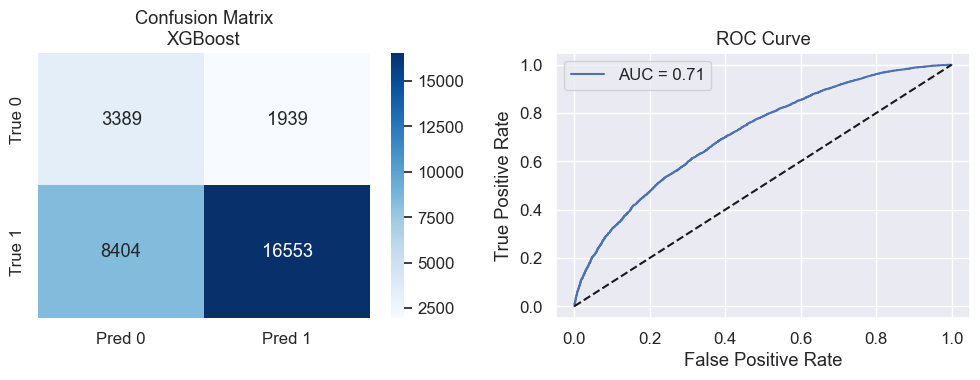

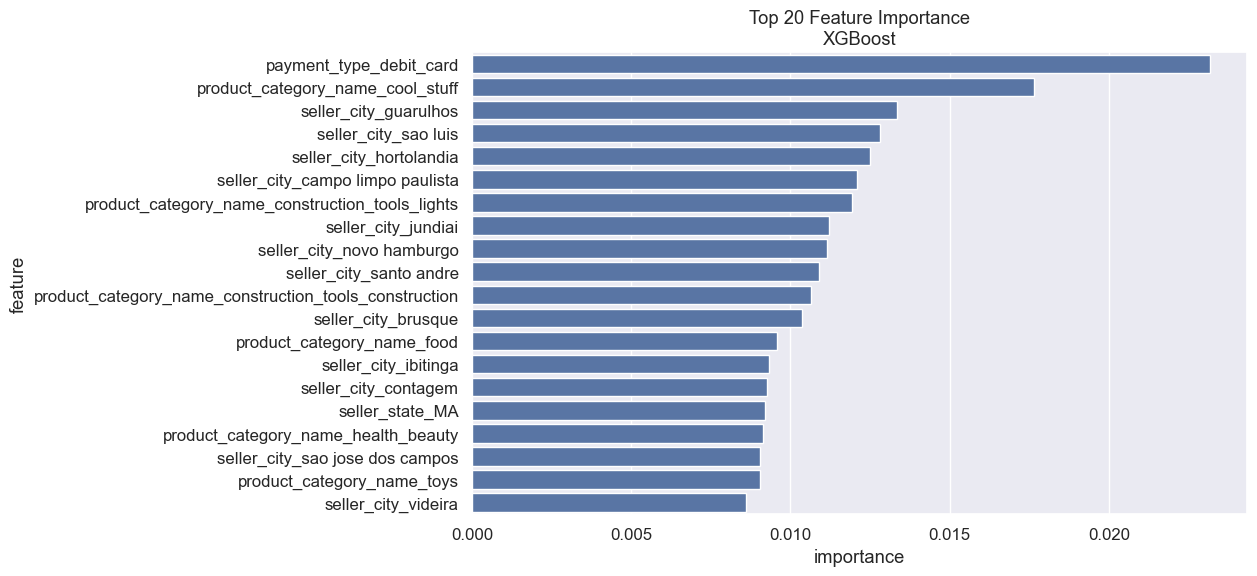


Модель XGBoost обучена и оценена!

Итоговое сравнение моделей:
                      roc_auc        f1  accuracy  sensitivity  specificity
XGBoost              0.714696  0.761951  0.658478     0.663261     0.636074
Logistic Regression  0.680839  0.766548  0.660525     0.676323     0.586524
Random Forest        0.656677  0.746205  0.635100     0.650960     0.560811
Decision Tree        0.569459  0.543956  0.451874     0.396682     0.710398


<Figure size 1200x600 with 0 Axes>

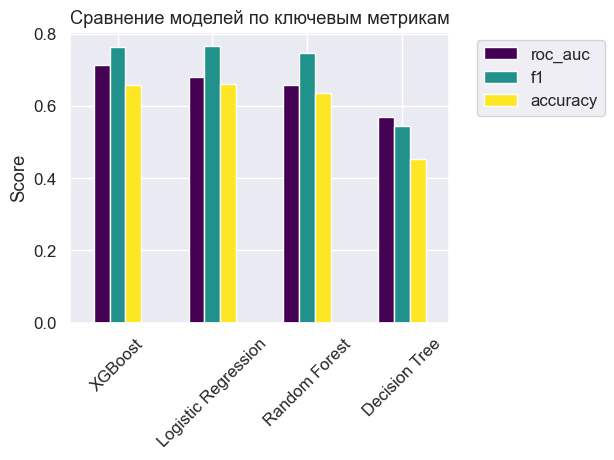

In [263]:
# 1. Функции для расчета метрик
def calculate_specificity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

def extended_classification_report(y_true, y_pred, y_proba, model_name):
    print(f"\n{'='*50}")
    print(f"Отчет по модели: {model_name}")
    print("="*50)
    
    print("Classification Report:")
    print(classification_report(y_true, y_pred))
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    metrics = {
        'specificity': calculate_specificity(y_true, y_pred),
        'sensitivity': recall_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred),
        'roc_auc': roc_auc_score(y_true, y_proba),
        'accuracy': accuracy_score(y_true, y_pred),
        'tp': tp,
        'tn': tn,
        'fp': fp,
        'fn': fn
    }
    
    print(f"Specificity (TNR): {metrics['specificity']:.4f}")
    print(f"Sensitivity (Recall/TPR): {metrics['sensitivity']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"F1 Score: {metrics['f1']:.4f}")
    print(f"ROC-AUC: {metrics['roc_auc']:.4f}")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print("\nConfusion Matrix:")
    print(f"True Positives: {tp}")
    print(f"True Negatives: {tn}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    
    return metrics

# 2. Создание пайплайна для обработки данных
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# 3. Функция для обучения и оценки модели
def train_and_evaluate(model, X_train, X_test, y_train, y_test, model_name):
    # Создание пайплайна
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    # Обучение модели
    pipeline.fit(X_train, y_train)
    
    # Предсказания
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]
    
    # Оценка качества
    metrics = extended_classification_report(y_test, y_pred, y_proba, model_name)
    
    # Визуализация
    plot_results(y_test, y_pred, y_proba, metrics, model_name, pipeline)
    
    return pipeline, metrics

def plot_results(y_test, y_pred, y_proba, metrics, model_name, pipeline):
    # Confusion Matrix
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    sns.heatmap(confusion_matrix(y_test, y_pred), 
                annot=True, fmt='d', cmap='Blues',
                xticklabels=['Pred 0', 'Pred 1'],
                yticklabels=['True 0', 'True 1'])
    plt.title(f'Confusion Matrix\n{model_name}')
    
    # ROC Curve
    plt.subplot(1, 2, 2)
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'AUC = {metrics["roc_auc"]:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Feature Importance (для tree-based моделей)
    if hasattr(model, 'feature_importances_'):
        try:
            # Для пайплайна получаем имена фичей после OneHotEncoding
            ohe_columns = list(pipeline.named_steps['preprocessor']
                              .named_transformers_['cat']
                              .get_feature_names_out(categorical_features))
            all_features = numerical_features + ohe_columns
            
            # Получаем важность фичей
            importances = pipeline.named_steps['classifier'].feature_importances_
            
            # Создаем DataFrame для визуализации
            feat_imp = pd.DataFrame({
                'feature': all_features,
                'importance': importances
            }).sort_values('importance', ascending=False).head(20)
            
            plt.figure(figsize=(10, 6))
            sns.barplot(x='importance', y='feature', data=feat_imp)
            plt.title(f'Top 20 Feature Importance\n{model_name}')
            plt.show()
        except Exception as e:
            print(f"Не удалось визуализировать важность признаков: {e}")

# 4. Подготовка данных
# Предположим, df - наш DataFrame с данными
X = merge6[numerical_features + categorical_features]
y = merge6['is_churned']  # Целевая переменная

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

# 5. Определение моделей
models = {
    'Logistic Regression': LogisticRegression(
        class_weight='balanced',
        max_iter=1000,
        random_state=42
    ),
    'Decision Tree': DecisionTreeClassifier(
        max_depth=5,
        min_samples_leaf=50,
        class_weight='balanced',
        random_state=42
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        max_depth=7,
        min_samples_leaf=30,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ),
    'XGBoost': xgb.XGBClassifier(
        objective='binary:logistic',
        n_estimators=150,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=np.sum(y_train == 0) / np.sum(y_train == 1),
        random_state=42,
        n_jobs=-1
    )
}

# 6. Обучение и оценка моделей
results = {}
for name, model in models.items():
    print(f"\n{'='*50}")
    print(f"Обучение модели: {name}")
    print("="*50)
    
    pipeline, metrics = train_and_evaluate(
        model, X_train, X_test, y_train, y_test, name)
    results[name] = metrics
    print(f"\nМодель {name} обучена и оценена!")

# 7. Сравнение моделей
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values('roc_auc', ascending=False)

print("\nИтоговое сравнение моделей:")
print(results_df[['roc_auc', 'f1', 'accuracy', 'sensitivity', 'specificity']])

# Визуализация сравнения
plt.figure(figsize=(12, 6))
results_df[['roc_auc', 'f1', 'accuracy']].plot(kind='bar', colormap='viridis')
plt.title('Сравнение моделей по ключевым метрикам')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()